### choose a gameId,PlayId
    example:
    gameId:2022091101
    playId=85
### clean and prepare the data
     1: add cloumn[official_position,is_carry_ball,x_qb,y_qb,angle,angle_diffrernce,pass_frame,possession_team,strain]
     2: distinguish the main effect: before the ball-caught focus on QB,after that, focus on ball_carrier

### $angle=\cot{\frac{|play_{y}-QB_{y}|}{|play_{x}-QB_{y}|}}$
### $angle(difference)=|angle-o|$

## 1 clean and prepare

In [188]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation 
game_data = pd.read_csv('tracking_week_5.csv')

In [189]:
print(game_data['gameId'].unique())

[2022100600 2022100900 2022100901 2022100902 2022100903 2022100904
 2022100905 2022100906 2022100907 2022100908 2022100909 2022100910
 2022100911 2022100912 2022100913 2022101000]


In [190]:
game_data=game_data[game_data['gameId']==2022100906]
print(game_data['playId'].unique())

[  65   86  107  131  156  177  210  235  322  343  367  392  413  493
  517  594  691  717  771  792  870  891  954 1004 1034 1058 1083 1104
 1202 1301 1322 1367 1388 1409 1500 1522 1597 1625 1680 1739 1823 1852
 1877 1927 1948 1990 2030 2058 2227 2267 2298 2324 2377 2522 2549 2681
 2763 2784 2810 2893 2936 3002 3072 3145 3174 3301 3322 3351 3376 3432
 3544 3633 3654 3675 3699 3724 3748 3807 3842 3863 3887 3953 4041 4062
 4083 4138 4159 4218 4239 4267 4298 4323]


In [191]:
game_data=game_data[game_data['playId']==2267]
print(game_data['event'].unique())

[nan 'ball_snap' 'handoff' 'first_contact' 'tackle']


#### (there is one important thing that during one single play in a game, there is only one chance to pass the ball from the BQ)

In [192]:
#add the colunm
players=pd.read_csv('players.csv')
plays=pd.read_csv('plays.csv')

In [193]:
# add the official_position
def get_position(name, players_df):
    player = players_df[players_df['displayName'] == name]
    if not player.empty:
        return player.iloc[0]['position']
    else:
        return None  # or some default value like 'Unknown'

# Apply the function to each row in game_data to create the new column
game_data['official_position'] = game_data['displayName'].apply(get_position, players_df=players)

In [194]:
# add the is_carry_ball
def check_ball_carrier(game_row, players_df):
    # Find the play in the players DataFrame that matches the gameId and playId
    play = players_df[(players_df['gameId'] == game_row['gameId']) & (players_df['playId'] == game_row['playId'])]
    # If the ballCarrierDisplayName matches the displayName, return 1, else return 0
    if not play.empty and game_row['displayName'] == play.iloc[0]['ballCarrierDisplayName']:
        return 1
    else:
        return 0

# Apply the function to each row in game_data
game_data['is_carry_ball'] = game_data.apply(check_ball_carrier, axis=1, players_df=plays)

In [195]:
def find_possession_team(game_row, plays_df):
    # Find the play in the players DataFrame that matches the gameId and playId
    play = plays_df[(plays_df['gameId'] == game_row['gameId']) & (plays_df['playId'] == game_row['playId'])]
    # If the play exists and contains the 'possessionTeam' column, return its value, else return None
    if not play.empty and 'possessionTeam' in play.columns:
        return play.iloc[0]['possessionTeam']
    else:
        return None

# Apply the function to each row in game_data and store the result in 'possessionteam' column
game_data['possessionteam'] = game_data.apply(find_possession_team, axis=1, plays_df=plays)

In [196]:
# add pass_frame
def assign_pass_frame(play_data, events_of_interest):
    # Group by playId to process each play separately
    grouped = play_data.groupby('playId')        
        # For each play, find the frame where the event occurred and assign it to all rows of that play
    for name, group in grouped:
        # Find the frameId where the event occurred
        event_frame = group[group['event'].isin(events_of_interest)]['frameId'].min()
        # If an event frame is found, assign it to the pass_frame column for the entire group
        if not pd.isna(event_frame):
            play_data.loc[play_data['playId'] == name, 'pass_frame'] = event_frame
        else:
            play_data.loc[play_data['playId'] == name, 'pass_frame'] = 1
    return play_data
    
# Define the events we are looking for    
events = ['handoff','run','pass_forward','lateral','pass_forward','pass_arrived']
game_data=assign_pass_frame(game_data,events)

In [197]:
# add end_frame
def assign_end_frame(play_data, events_of_interest):
    # Group by playId to process each play separately
    grouped = play_data.groupby('playId')
    
    # For each play, find the frame where the event occurred and assign it to all rows of that play
    for name, group in grouped:
        # Find the frameId where the event occurred
        event_frame = group[group['event'].isin(events_of_interest)]['frameId'].min()
        # If an event frame is found, assign it to the pass_frame column for the entire group
        if not pd.isna(event_frame):
            play_data.loc[play_data['playId'] == name, 'end_frame'] = event_frame
    
    return play_data

# Define the events we are looking for
events = ['out_of_bounds', 'tackle','touchdown','qb_sack','qb_slide']
game_data=assign_end_frame(game_data,events)


In [198]:
#add x-qb,y-qb
def qb_coordinates(frame_group):
    # Find the QB in the frame
    qb_row = frame_group[frame_group['is_carry_ball'] == 1]
    if not qb_row.empty:
        # Get the QB's x and y coordinates
        x_qb, y_qb = qb_row.iloc[0]['x'], qb_row.iloc[0]['y']
        # Calculate the difference for each player in the frame
        frame_group['x_qb'] = frame_group['x'] - x_qb
        frame_group['y_qb'] = frame_group['y'] - y_qb
        frame_group['s_strain']=np.sqrt((frame_group['x'] - x_qb)**2 + (frame_group['y'] - y_qb)**2)
        frame_group['angle'] = frame_group.apply(lambda row: math.atan2(abs(row['x'] - x_qb),abs(row['y'] - y_qb)), axis=1)
        frame_group['angle'] = frame_group['angle'].apply(math.degrees)
    return frame_group

# Group by frameId and apply the function
game_data = game_data.groupby('frameId').apply(qb_coordinates).reset_index(drop=True)
game_data.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,event,official_position,is_carry_ball,possessionteam,pass_frame,end_frame,x_qb,y_qb,s_strain,angle
0,2022100906,2267,35562.0,Al Woods,1,2022-10-09 14:52:50.099999,99.0,SEA,left,39.38,...,NaN,NT,0,NO,20.0,52.0,-9.58,0.20,9.582087,88.804020
1,2022100906,2267,37110.0,Andy Dalton,1,2022-10-09 14:52:50.099999,14.0,NO,left,42.38,...,NaN,QB,0,NO,20.0,52.0,-6.58,0.31,6.587298,87.302649
2,2022100906,2267,41464.0,Shelby Harris,1,2022-10-09 14:52:50.099999,93.0,SEA,left,39.41,...,NaN,DE,0,NO,20.0,52.0,-9.55,-2.75,9.938058,73.935816
3,2022100906,2267,41532.0,James Hurst,1,2022-10-09 14:52:50.099999,74.0,NO,left,41.83,...,NaN,T,0,NO,20.0,52.0,-7.13,-3.16,7.798878,66.097186
4,2022100906,2267,42356.0,Andrus Peat,1,2022-10-09 14:52:50.099999,75.0,NO,left,41.86,...,NaN,G,0,NO,20.0,52.0,-7.10,-1.33,7.223496,79.390090


#### since we got 10frames/second
## $STRAIN(t)=\frac{-\frac{s(t)-s(t-1)}{0.1}}{s(t)}$

In [199]:
# add the strain
def calculate_player_strain(player_group):
    # Sort the player's data by frameId to ensure it's in chronological order
    player_group = player_group.sort_values(by='frameId')
    # Identify the clubs of players who are carrying the ball

    # Calculate strain for each player, but skip the first frame
    if len(player_group) > 1:
        # Calculate the difference between s_strain values of the current frame and the previous frame for the same player
        player_group['strain'] = (-((player_group['s_strain'] - player_group['s_strain'].shift(1)) / 0.1) / player_group['s_strain']).fillna(0)
    return player_group
# Separate football data
football_data = game_data[game_data['club'] == 'football']

# Separate player data
player_data = game_data[game_data['club'] != 'football']

# Apply the strain calculation to player data
player_data = player_data.groupby('nflId').apply(calculate_player_strain).reset_index(drop=True)

# Recombine player data with football data
game_data = pd.concat([player_data, football_data], ignore_index=True)
carry_ball_clubs = game_data[game_data['is_carry_ball'] == 1]['club'].unique()
# For players in these clubs, set 'strain' to 0
game_data.loc[game_data['club'].isin(carry_ball_clubs), 'strain'] = 0

In [200]:
def calculate_vector(frame_group):
    # Calculate the vector for each player in the frame
    for index, row in frame_group.iterrows():
        dir = row['dir']
        x = math.sin(math.radians(180 - dir))
        y = math.cos(math.radians(180 - dir))
        frame_group.at[index, 'vector_x'] = x
        frame_group.at[index, 'vector_y'] = y
    
    return frame_group

# Group by frameId and apply the function
game_data = game_data.groupby('frameId').apply(calculate_vector).reset_index(drop=True)

In [201]:
import pandas as pd
import numpy as np

# Function to calculate dot product
def dot_product(vec1, vec2):
    return np.dot(vec1, vec2)

# Function to check if a vector is valid (not NaN)
def is_valid_vector(vector):
    return not np.isnan(vector).any()


df = game_data

# Add the 'BULLE' column to the dataframe
df['delta_angle'] = 0

# Identify the clubs of players who are carrying the ball
carry_ball_clubs = df[df['is_carry_ball'] == 1]['club'].unique()



# Processing each row for dot product calculations
for index, row in df.iterrows():
    frame = row['frameId']
    player_vector = np.array([row['vector_x'], row['vector_y']])

    # Initialize default values for vectors
    current_vector = np.array([np.nan, np.nan])
    pre_vector = np.array([np.nan, np.nan])

    # Get current_vector for frameId == frame and is_carry_ball == 1
    current_vector_row = df[(df['frameId'] == frame) & (df['is_carry_ball'] == 1)]
    if not current_vector_row.empty:
        current_vector = np.array([current_vector_row.iloc[0]['vector_x'], current_vector_row.iloc[0]['vector_y']])

    # Get pre_vector for frameId == frame - 1 and is_carry_ball == 1
    pre_vector_row = df[(df['frameId'] == frame - 1) & (df['is_carry_ball'] == 1)]
    if not pre_vector_row.empty:
        pre_vector = np.array([pre_vector_row.iloc[0]['vector_x'], pre_vector_row.iloc[0]['vector_y']])

    # Check if both current and previous vectors are valid before calculating dot products
    if is_valid_vector(current_vector) and is_valid_vector(pre_vector) and is_valid_vector(player_vector):
        # Compute dot products
        dot_product_pre = dot_product(pre_vector, player_vector)
        dot_product_current = dot_product(current_vector, player_vector)

        # Set the current row's 'BULLE' as the difference between the two dot products
        df.at[index, 'delta_angle'] = dot_product_current - dot_product_pre
    else:
        # Set default value if vectors are not valid
        df.at[index, 'delta_angle'] = 0
# For players in these clubs, set 'BULLE' to 0
df.loc[df['club'].isin(carry_ball_clubs), 'delta_angle'] = 0
df['BULLE'] = df['strain'] * df['delta_angle'] + df['delta_angle']+df['strain']
# 1. 获取值["pass_frame", 'end_frame']
pass_frame = int(game_data['pass_frame'].values[0])  # 假设'pass_frame'列中所有值都相同
end_frame = int(game_data['end_frame'].values[0])  # 假设'end_frame'列中所有值都相同

# 2. 对于每个球员，如果['frameId']小于pass_frame或大于'end_frame'，则将['BULLE']设置为0
game_data['BULLE'] = game_data.apply(lambda row: 0 if (int(row['frameId']) < pass_frame or int(row['frameId']) > end_frame) else row['BULLE'], axis=1)



## visualization

In [202]:
# draw the background
# Adjusting the football field drawing function to match the provided screenshot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_football_field_labeled(ax):
    """
    This function draws a football field as per the dimensions and markings seen in the provided screenshot.
    """
    # Field dimensions
    field_length = 120
    field_width = 53.3
    end_zone_length = 10  # Length of end zone on both sides
    
    # Create a rectangle for the field area
    field = patches.Rectangle((0, 0), field_length, field_width, linewidth=0.1, edgecolor='gray', facecolor='gray', zorder=0)
    ax.add_patch(field)
    
    # Add end zones
    end_zone1 = patches.Rectangle((0, 0), end_zone_length, field_width, linewidth=0.1, edgecolor='blue', facecolor='gray', alpha=0.2, zorder=1)
    end_zone2 = patches.Rectangle((field_length-end_zone_length, 0), end_zone_length, field_width, linewidth=0.1, edgecolor='blue', facecolor='gray', alpha=0.2, zorder=1)
    ax.add_patch(end_zone1)
    ax.add_patch(end_zone2)
    
    # Add yard lines and hashes
    for x in range(10, field_length, 10):
        ax.plot([x, x], [0, field_width], color="white", zorder=2)  # Full yard line across the field
        # Drawing the small hash marks on each side of the field
        for y in range(0, int(field_width)+1, 1):
            if y % 10 == 0:  # Major yard line
                hash_length = 0.8
            else:  # Minor yard line
                hash_length = 0.4
            ax.plot([x-hash_length, x+hash_length], [y, y], color="white", zorder=2)
    
    # Add numbers every ten yards
    for x in range(20, field_length, 10):
        ax.text(x-2, 12, str(x-10), color="white", size='small', verticalalignment='center', horizontalalignment='center', zorder=3)
        ax.text(x-2, field_width-12, str(x-10), color="white", size='small', verticalalignment='center', horizontalalignment='center', zorder=3, rotation=180)
    
    # Set the limits of the field to a bit beyond the actual field for a nicer view
    ax.set_xlim(-5, field_length+5)
    ax.set_ylim(-5, field_width+5)
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Set aspect to be equal so the field is not skewed
    ax.set_aspect(aspect='equal')

In [203]:
game_data.to_csv('1.csv')

In [204]:
# Create the animation
max_frame = game_data['frameId'].max()
unique_clubs = game_data['club'].unique()
football = game_data[game_data['club'] == 'football']
players_club1 = game_data[game_data['club'] =='NO' ]
players_club2 = game_data[game_data['club'] =='SEA' ]

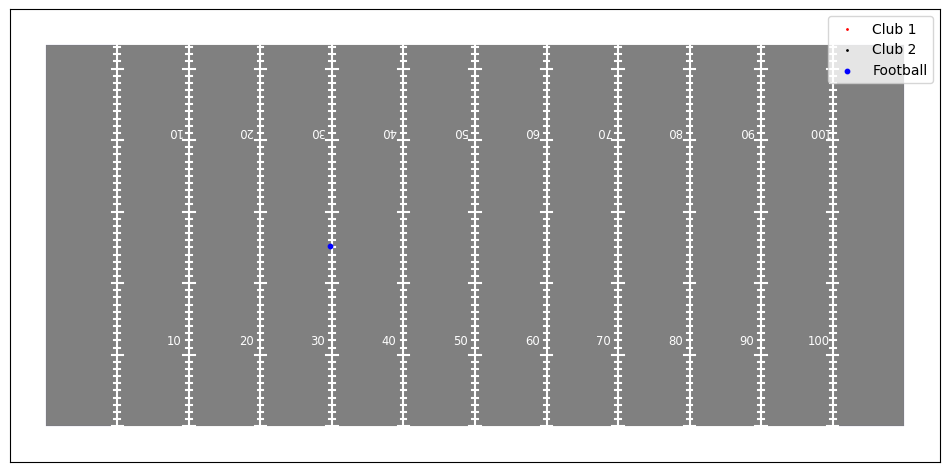

In [79]:
# 原始版本
def animate(frame_id):
    ax.clear()
    draw_football_field_labeled(ax)
    players_club1_frame = players_club1[players_club1['frameId'] == frame_id]
    players_club2_frame = players_club2[players_club2['frameId'] == frame_id]
    football_frame = football[football['frameId'] == frame_id]

    # Adjust circle sizes based on strain and strain_assistance
    #size_club1 = players_club1_frame.apply(lambda row: max(5, (row['strain']*100), axis=1)
    #size_club2 = players_club2_frame.apply(lambda row: max(5, (row['strain']*100), axis=1)
    size_club1 = players_club1_frame.apply(lambda row: max(5, (row['BULLE'])*200 ), axis=1)
    size_club2 = players_club2_frame.apply(lambda row: max(5, (row['BULLE'])*200 ), axis=1)
    ax.scatter(players_club1_frame['x'], players_club1_frame['y'], s=size_club1, color='red', label='Club 1',zorder=5)
    ax.scatter(players_club2_frame['x'], players_club2_frame['y'], s=size_club2, color='black', label='Club 2',zorder=5)
    ax.scatter(football_frame['x'], football_frame['y'], color='blue', s=10, label='Football',zorder=5)  # Fixed size for football
    ax.legend(loc='upper right')



fig, ax = plt.subplots(figsize=(12, 6.66))
draw_football_field_labeled(ax)
ani = animation.FuncAnimation(fig, animate, frames=max_frame, interval=100)

# Save the animation as a GIF using Pillow
ani.save('player_movement_animation.gif', writer='pillow', fps=10)  # Adjust fps as needed

plt.show()

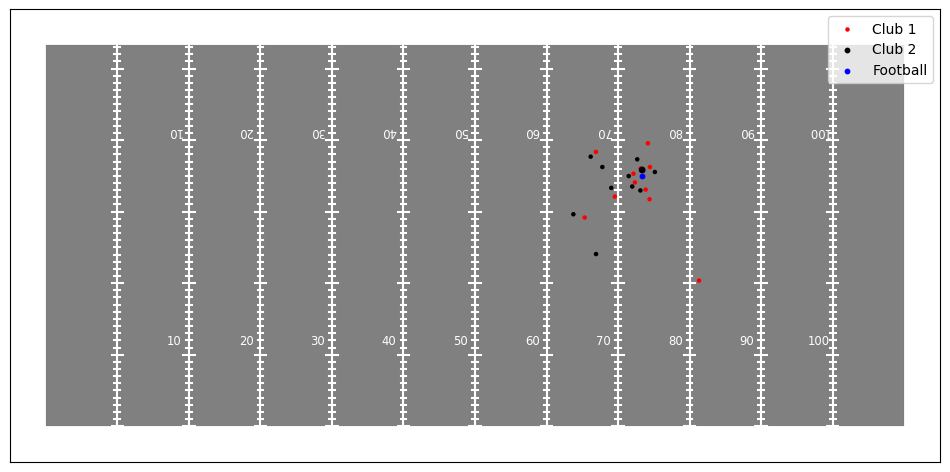

In [224]:
# 指定名字球员变大
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def set_marker_size(player):
    if player['displayName'] == 'Brian Burns':
        return 15  # Set a specific size for the player with the specific display name
    else:
        return 5  # Set a default size for other players

# Function to animate each frame
def animate(frame_id):
    ax.clear()
    draw_football_field_labeled(ax)
    players_club1_frame = players_club1[players_club1['frameId'] == frame_id]
    players_club2_frame = players_club2[players_club2['frameId'] == frame_id]
    football_frame = football[football['frameId'] == frame_id]

    size_club1 = players_club1_frame.apply(set_marker_size, axis=1)
    size_club2 = players_club2_frame.apply(set_marker_size, axis=1)

    ax.scatter(players_club1_frame['x'], players_club1_frame['y'], s=size_club1, color='red', label='Club 1', zorder=5)
    ax.scatter(players_club2_frame['x'], players_club2_frame['y'], s=size_club2, color='black', label='Club 2', zorder=5)
    ax.scatter(football_frame['x'], football_frame['y'], color='blue', s=10, label='Football', zorder=5)

    ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(12, 6.66))
draw_football_field_labeled(ax)
ani = animation.FuncAnimation(fig, animate, frames=max_frame, interval=100)

# Save the animation as a GIF using Pillow
ani.save('player_movement_animation.gif', writer='pillow', fps=10)  # Adjust fps as needed

plt.show()


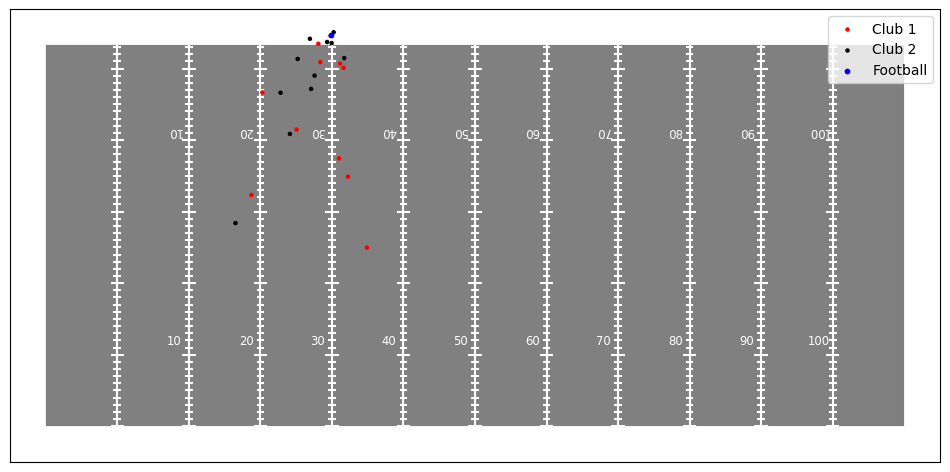

In [205]:
#最大BULLE显示黄色
def animate(frame_id):
    ax.clear()
    draw_football_field_labeled(ax)
    players_club1_frame = players_club1[players_club1['frameId'] == frame_id]
    players_club2_frame = players_club2[players_club2['frameId'] == frame_id]
    football_frame = football[football['frameId'] == frame_id]

    # Adjust circle sizes based on strain and strain_assistance
    size_club1 = players_club1_frame.apply(lambda row: max(5, (row['strain'])*(row['delta_angle'])*200 ), axis=1)
    size_club2 = players_club2_frame.apply(lambda row: max(5, (row['strain'])*(row['delta_angle'])*200 ), axis=1)
    
    # Check if there are any rows in the DataFrames
    if not players_club1_frame.empty:
        # Find the player with the maximum 'BULLE' value in Club 1
        max_bulle_player_club1 = players_club1_frame.loc[players_club1_frame['BULLE'].idxmax()]
        max_bulle_value_club1 = max_bulle_player_club1['BULLE']
        ax.scatter(players_club1_frame['x'], players_club1_frame['y'], s=size_club1, color='red', label='Club 1',zorder=5)
        if max_bulle_value_club1 > 0:
            ax.scatter(max_bulle_player_club1['x'], max_bulle_player_club1['y'], s=size_club1.loc[max_bulle_player_club1.name], color='yellow', label='Club 1 (Max BULLE)', zorder=5)
    
    if not players_club2_frame.empty:
        # Find the player with the maximum 'BULLE' value in Club 2
        max_bulle_player_club2 = players_club2_frame.loc[players_club2_frame['BULLE'].idxmax()]
        max_bulle_value_club2 = max_bulle_player_club2['BULLE']
        ax.scatter(players_club2_frame['x'], players_club2_frame['y'], s=size_club2, color='black', label='Club 2',zorder=5)
        if max_bulle_value_club2 > 0:
            ax.scatter(max_bulle_player_club2['x'], max_bulle_player_club2['y'], s=size_club2.loc[max_bulle_player_club2.name], color='yellow', label='Club 2 (Max BULLE)', zorder=5)

    ax.scatter(football_frame['x'], football_frame['y'], color='blue', s=10, label='Football',zorder=5)  # Fixed size for football
    ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(12, 6.66))
draw_football_field_labeled(ax)
ani = animation.FuncAnimation(fig, animate, frames=max_frame, interval=100)

# Save the animation as a GIF using Pillow
ani.save('player_movement_animation.gif', writer='pillow', fps=10)  # Adjust fps as needed

plt.show()


# cumulative calculate the strain in every play and ranking the player

# add a new matric to value the man help to get score

### $motion\ vector(RU)=(\sin(\frac{180-dir_{t}^{RU}}{180}\pi),\cos(\frac{180-dir_{t}^{RU}}{180}\pi))$
### $angle=motion\ vector(RU) \cdot motion\ vector(j)$
### $\Delta \overrightarrow{angle}=angle_{t}-angle_{t-1}$
    RU: the palyer who carry the football,
    j:the defence player
    t:the frame

#### simply demonstrate the $\Delta angle$ goes bigger when the defence player play a nice role to stop offence

![Image Alt Text](vector.svg)

### $$\Delta S=\sqrt{(x^{RU}-x_j)^2+(y^{RU}-y_j)^2}$$

### $$BULLY={\frac{\Delta S_{t-1}-\Delta S_{t}}{0.1 \cdot{\Delta S_t}}*angle}$$

In [206]:
data=pd.read_csv('1.csv')
data=data[['displayName','frameId','BULLE','dir','s']]
data.head()

,displayName,frameId,BULLE,dir,s
0,Al Woods,1,0.0,72.09,0.00
1,Andy Dalton,1,0.0,317.48,0.50
2,Shelby Harris,1,0.0,75.58,0.00
3,James Hurst,1,0.0,38.01,0.00
4,Andrus Peat,1,0.0,322.69,0.04


/var/folders/hd/zd7rnk9n0453drzkfxq8n1w00000gn/T/ipykernel_1215/1839568200.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alvin_kamara_data['computed_column'] = alvin_kamara_data['s'] * np.sin(np.radians(180 - alvin_kamara_data['dir']))


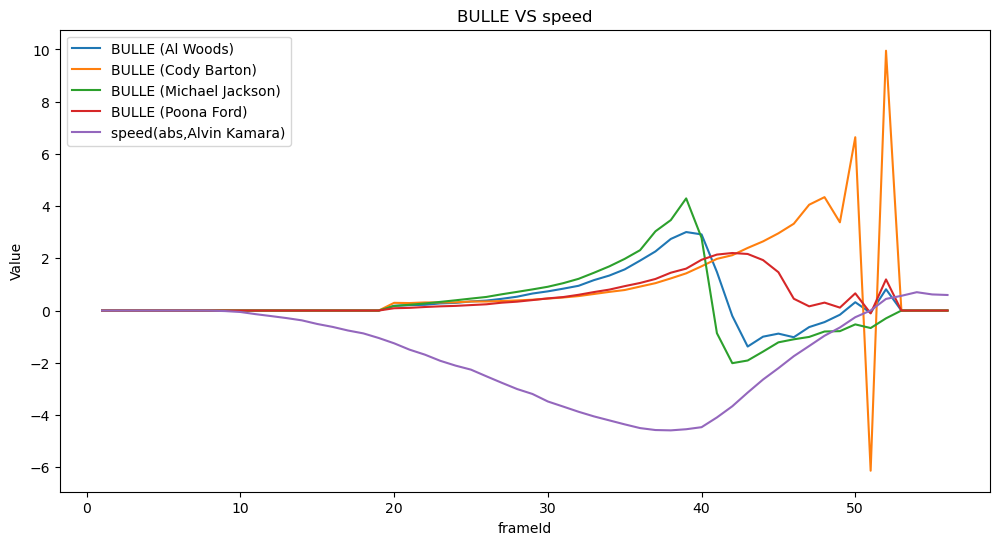

In [213]:
# 创建一个包含所需玩家的列表
players = ['Al Woods', 'Cody Barton', 'Michael Jackson', 'Poona Ford']

# 创建一个坐标轴对象
fig, ax = plt.subplots(figsize=(12, 6))

# 循环遍历每个玩家并绘制相应的曲线
for player in players:
    player_data = data[data['displayName'] == player]
    ax.plot(player_data['frameId'], player_data['BULLE'], label=f'BULLE ({player})')

# 计算并绘制Alvin Kamara的计算列随时间变化曲线
alvin_kamara_data = data[data['displayName'] == 'Alvin Kamara']
alvin_kamara_data['computed_column'] = alvin_kamara_data['s'] * np.sin(np.radians(180 - alvin_kamara_data['dir']))
ax.plot(alvin_kamara_data['frameId'], alvin_kamara_data['computed_column'], label='speed(abs,Alvin Kamara)')

# 设置坐标轴标签和标题
ax.set_xlabel('frameId')
ax.set_ylabel('Value')
ax.set_title('BULLE VS speed')

# 添加图例
ax.legend()

# 显示图形
plt.show()